# Multi-Agent Deep Deterministic Policy Gradient for Tennis

---

In this notebook, we have implemented the [Multi-Agent Deep Deterministic Policy Gradient (MADDPG)](https://arxiv.org/abs/1706.02275) reinforcement learning algorithm for a simulated tennis game. This is for the second project of the [Udacity Deep Reinforcement Learning Nanodegree program](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### Setup

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md).

In [1]:
import copy
import torch
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Create and Examine The Tennis Environment

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. The last 3 observations are stacked for a total of 24. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [2]:
env = UnityEnvironment(file_name="/home/sebastian/udacity_drl/drlnd-multiagent-project/Tennis_Linux/Tennis.x86_64")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 
Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### Create and Train MADDPG Agent

We will define two MADDPG agents, one for each tennis player.

While each actor operates completely locally (local observations to local actions), the critic accepts both agents' observations and actions and produces a local Q-function estimate for the agent.

In [3]:
from maddpg import MADDPGAgent
from utils import ReplayBuffer

# DDPG parameters
GAMMA = 0.99                # Discount factor
TAU = 2e-3                  # Soft update weight for target networks

# Training parameters
NUM_EPISODES = 2000         # Total number of episodes
MAX_EPISODE_SCORE = 2.5     # Score to end an episode (to prevent long games) 
AVG_WINDOW_SIZE = 100       # Window size to average scores
TRAINING_END_SCORE = 1.0    # Max average return value that ends training
BATCH_SIZE = 128            # Batch size for training
UPDATE_EVERY = 5            # Number of time steps between training steps
NUM_UPDATES = 10            # Number of iterations per training step
REPLAY_BUF_SIZE = int(5e5)  # Replay buffer size
LR_ACTOR = 2e-4             # Learning rate for actor network
LR_CRITIC = 1e-3            # Learning rate for critic network
WEIGHT_DECAY_ACTOR = 1e-6   # Regularization gain for actor network weights
WEIGHT_DECAY_CRITIC = 1e-5  # Regularization gain for critic network weights
CLIP_GRAD = 1.0             # Clip value for gradients during training

# OU Noise decay parameters
INIT_NOISE = 0.5            # Initial scale
MIN_NOISE = 0.05            # Minimum noise scale
NOISE_DECAY = 2.5e-5        # Noise scale decay factor 
                            # (SCALE <-- SCALE*(1-NOISE_DECAY))

# Reproducibility by fixing random seed
SEED = 4321
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Create agents and replay buffer
agents = [MADDPGAgent(num_agents=num_agents, gamma=GAMMA, tau=TAU,
                      lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, 
                      weight_decay_actor=WEIGHT_DECAY_ACTOR, 
                      weight_decay_critic=WEIGHT_DECAY_CRITIC) 
          for _ in range(num_agents)]
buffer = ReplayBuffer(size=REPLAY_BUF_SIZE)

# Training Loop
noise = INIT_NOISE
best_score = 0
scores_vec = []
scores_avg_vec = []
scores_window = deque(maxlen=AVG_WINDOW_SIZE)
num_steps = 0
num_episodes = 0
steps_vec = []
training_done = False
while not training_done:

    # Reset the environment
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    scores = np.zeros(num_agents)
    for agent in agents:
        agent.noise.reset()

    # Run an episode
    ep_done = False
    while not ep_done:

        # Choose actions from the agents
        with torch.no_grad():
            actions = np.zeros((num_agents, action_size))
            for aidx in range(num_agents):
                state_tensor = torch.tensor(states[aidx], dtype=torch.float)
                act_tensor = agents[aidx].act(state_tensor.cuda(), noise=noise)
                actions[aidx, :] = act_tensor.cpu().detach().numpy()

        # Step the environment and collect data
        env_info = env.step(actions)[brain_name]        # send all actions to the environment
        next_states = env_info.vector_observations      # get next state (for each agent)
        rewards = env_info.rewards                      # get reward (for each agent)
        dones = env_info.local_done                     # see if episode finished
        scores += env_info.rewards                      # update the score (for each agent)
        
        # Push to the experience buffer
        for aidx in range(num_agents):
            experience = (states[aidx], actions[aidx], [rewards[aidx]], 
                        next_states[aidx], [dones[aidx]], 
                        states, next_states, actions)
            buffer.push(experience)

        # Update the agents once the buffer is sufficiently full
        if len(buffer) > BATCH_SIZE and num_steps % UPDATE_EVERY == 0:
            for _ in range(NUM_UPDATES):
                for agent in agents:
                    samples = buffer.sample(BATCH_SIZE)
                    agent.train(samples)

        # Update the time step index and decay noise
        num_steps += 1
        noise = max(MIN_NOISE, noise*(1-NOISE_DECAY))

        # Roll over next state and terminate if needed
        states = next_states
        if np.any(dones) or max(scores) >= MAX_EPISODE_SCORE:
            ep_done = True
            num_episodes += 1
    
    # Update the average scores
    max_score = max(scores)
    scores_vec.append(max_score)
    scores_window.append(max_score)
    mean_max_score = np.mean(scores_window)
    scores_avg_vec.append(mean_max_score)
    steps_vec.append(num_steps)

    # Save the best model so far
    if mean_max_score > best_score:
        for aidx in range(num_agents):
            torch.save(agents[aidx].actor.state_dict(), "best_weights_{}.pth".format(aidx))

    # If the best agent beats the score upper bound, training is complete
    if mean_max_score >= TRAINING_END_SCORE:
        training_done = True

    # Periodically print progress
    if num_episodes % AVG_WINDOW_SIZE == 0 or num_episodes == 1 or training_done: 
        print("\rEpisode: {} -- Steps: {} -- Max Average Score: {:.3f}".format(
              num_episodes, num_steps, mean_max_score))

Episode: 1 -- Steps: 15 -- Max Average Score: 0.000
Episode: 100 -- Steps: 1507 -- Max Average Score: 0.003
Episode: 200 -- Steps: 3070 -- Max Average Score: 0.009
Episode: 300 -- Steps: 4501 -- Max Average Score: 0.000
Episode: 400 -- Steps: 6306 -- Max Average Score: 0.019
Episode: 500 -- Steps: 8515 -- Max Average Score: 0.040
Episode: 600 -- Steps: 11353 -- Max Average Score: 0.064
Episode: 700 -- Steps: 13948 -- Max Average Score: 0.055
Episode: 800 -- Steps: 17110 -- Max Average Score: 0.072
Episode: 900 -- Steps: 21870 -- Max Average Score: 0.130
Episode: 1000 -- Steps: 26604 -- Max Average Score: 0.134
Episode: 1100 -- Steps: 31309 -- Max Average Score: 0.124
Episode: 1200 -- Steps: 35433 -- Max Average Score: 0.112
Episode: 1300 -- Steps: 41292 -- Max Average Score: 0.149
Episode: 1400 -- Steps: 47552 -- Max Average Score: 0.161
Episode: 1500 -- Steps: 53073 -- Max Average Score: 0.140
Episode: 1600 -- Steps: 59954 -- Max Average Score: 0.183
Episode: 1700 -- Steps: 70561 -- M

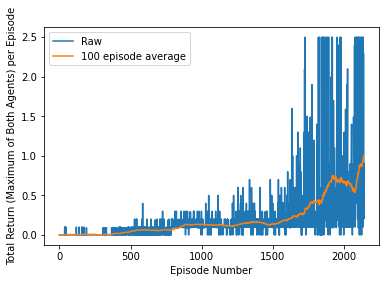

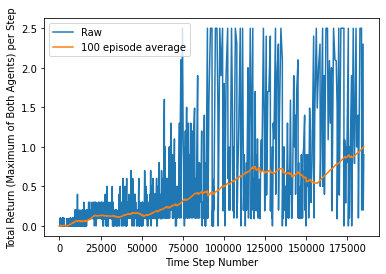

In [4]:
# Plot the final scores
plt.figure()
plt.plot(np.arange(len(scores_vec)), scores_vec)
plt.plot(np.arange(len(scores_avg_vec)), scores_avg_vec)
plt.xlabel("Episode Number")
plt.ylabel("Total Return")
plt.title("Training Progress by Episode")
plt.legend(["Raw", "{} episode average".format(AVG_WINDOW_SIZE)])
plt.show()

plt.figure()
plt.plot(steps_vec, scores_vec)
plt.plot(steps_vec, scores_avg_vec)
plt.xlabel("Time Step Number")
plt.ylabel("Total Return")
plt.title("Training Progress by Step")
plt.legend(["Raw", "{} episode average".format(AVG_WINDOW_SIZE)])
plt.show()

### Test the Trained Agent

Now we will take the best actor weights from training and use it for self-play. 

That is, both players will use the same actor with no added OU noise.

In [5]:
# Create a new actor network and assign it the trained weights
from networks import ActorNetwork
actors = []
for aidx in range(num_agents):
    actor = ActorNetwork().to(device)
    actor.load_state_dict(torch.load("best_weights_{}.pth".format(aidx)))
    actors.append(actor)

# Training Loop
env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations
scores = np.zeros(num_agents)

# Run an episode
MAX_STEPS = 1000
ep_done = False
num_steps = 0
while not ep_done:

    # Choose actions for both agents using the trained actor
    with torch.no_grad():
        actions = np.zeros((num_agents, action_size))
        for aidx in range(num_agents):
            state_tensor = torch.tensor(states[aidx], dtype=torch.float)
            act_tensor = actors[aidx](state_tensor.cuda())
            actions[aidx, :] = act_tensor.cpu().detach().numpy()

    # Step the environment and collect data
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    scores += env_info.rewards
    states = next_states
    num_steps += 1

    # Termination condition
    if np.any(dones) or num_steps >= MAX_STEPS:
        ep_done = True

print("Final scores after {} steps: {}".format(num_steps, scores))

Final scores after 1000 steps: [2.60000004 2.60000004]


In [6]:
# Finally, close the environment
env.close()